# **Define of Model**

In [1]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
def boas_buck(n, x, a, b):
    if n == 0:
        return torch.ones_like(x)
    elif n == 1:
        return (a[0] * x - b[0]) / (a[1] - b[1])
    else:
        return ((a[n-1] * x - b[n-1]) * boas_buck(n-1, x, a, b) - (a[n-2] - b[n-2]) * boas_buck(n-2, x, a, b)) / (a[n] - b[n])

class BoasBuckKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(BoasBuckKANLayer, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.degree = degree

        self.a = nn.Parameter(torch.randn(degree + 1))
        self.b = nn.Parameter(torch.randn(degree + 1))

        self.boas_buck_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.boas_buck_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))

    def forward(self, x):
        # Normalize x to [0, 1] using sigmoid
        x = torch.sigmoid(x)

        # Compute the Boas-Buck basis functions
        boas_buck_basis = []
        for n in range(self.degree + 1):
            boas_buck_basis.append(boas_buck(n, x, self.a, self.b))
        boas_buck_basis = torch.stack(boas_buck_basis, dim=-1)  # shape = (batch_size, input_dim, degree + 1)

        # Compute the Boas-Buck interpolation
        y = torch.einsum("bid,iod->bo", boas_buck_basis, self.boas_buck_coeffs)  # shape = (batch_size, output_dim)
        y = y.view(-1, self.output_dim)

        return y

class MNISTBoasBuckKAN(nn.Module):
    def __init__(self):
        super(MNISTBoasBuckKAN, self).__init__()
        self.trigkan1 = BoasBuckKANLayer(input_dim=784, output_dim=32, degree=3)
        self.bn1 = nn.LayerNorm(32)
        self.trigkan2 = BoasBuckKANLayer(input_dim=32, output_dim=32, degree=3)
        self.bn2 = nn.LayerNorm(32)
        self.trigkan3 = BoasBuckKANLayer(input_dim=32, output_dim=10, degree=3)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.trigkan1(x)
        x = self.bn1(x)
        x = self.trigkan2(x)
        x = self.bn2(x)
        x = self.trigkan3(x)
        return x

In [4]:
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as n
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 10



criterion = nn.CrossEntropyLoss()


def train(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    
    for idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        if isinstance(optimizer, optim.LBFGS):
            def closure():
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                return loss
            loss = optimizer.step(closure)
        else:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            loss = loss.item()
            
        total_loss += loss
        
    return total_loss / len(train_loader)

def validate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    return total_loss / len(test_loader), correct / len(test_loader.dataset)

In [5]:
Model_Names=['Boas-Buck']
model0 = MNISTBoasBuckKAN().to(device)
models=[model0]
total_params = sum(p.numel() for p in model0.parameters() if p.requires_grad)
print(f"Total trainable parameters of {Model_Names[0]}: {total_params}")


Total trainable parameters of Boas-Buck: 105880


# **Training of Model**

Boas-Buck, Epoch 1, Train Loss: 1.2609, Test Loss: 0.3994, Test Acc: 0.88
Boas-Buck, Epoch 2, Train Loss: 0.3905, Test Loss: 0.3198, Test Acc: 0.90
Boas-Buck, Epoch 3, Train Loss: 0.3218, Test Loss: 0.2821, Test Acc: 0.91
Boas-Buck, Epoch 4, Train Loss: 0.2743, Test Loss: 0.2426, Test Acc: 0.93
Boas-Buck, Epoch 5, Train Loss: 0.2473, Test Loss: 0.2400, Test Acc: 0.93
Boas-Buck, Epoch 6, Train Loss: 0.2237, Test Loss: 0.2008, Test Acc: 0.94
Boas-Buck, Epoch 7, Train Loss: 0.2022, Test Loss: 0.2084, Test Acc: 0.93
Boas-Buck, Epoch 8, Train Loss: 0.1864, Test Loss: 0.1836, Test Acc: 0.94
Boas-Buck, Epoch 9, Train Loss: 0.1734, Test Loss: 0.1684, Test Acc: 0.95
Boas-Buck, Epoch 10, Train Loss: 0.6357, Test Loss: 0.2421, Test Acc: 0.93
Boas-Buck, Epoch 11, Train Loss: 0.2190, Test Loss: 0.2340, Test Acc: 0.92
Boas-Buck, Epoch 12, Train Loss: 0.1943, Test Loss: 0.1855, Test Acc: 0.94
Boas-Buck, Epoch 13, Train Loss: 0.1789, Test Loss: 0.1654, Test Acc: 0.95
Boas-Buck, Epoch 14, Train Loss: 0

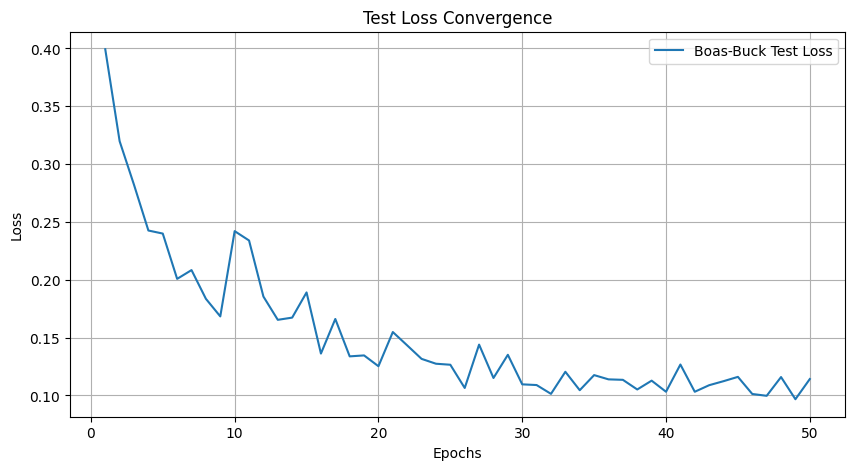

Boas-Buck processing time: 1220.49 seconds


In [6]:
import time

epochs = 50

def train_and_validate(models, model_names, train_loader, test_loader, criterion, optimizers, device, epochs):
    train_losses = [[] for _ in range(len(models))]
    test_losses = [[] for _ in range(len(models))]
    best_weights = [None] * len(models)
    best_test_losses = [float('inf')] * len(models)
    model_times = [0.0] * len(models)  # Initialize a list to store processing time for each model

    for epoch in range(epochs):
        for i, (model, optimizer) in enumerate(zip(models, optimizers)):
            start_time = time.time()  # Record the start time

            train_loss = train(model, train_loader, criterion, optimizer, device)
            test_loss, test_accuracy = validate(model, test_loader, criterion, device)

            end_time = time.time()  # Record the end time
            model_times[i] += end_time - start_time  # Accumulate the processing time for the current model

            train_losses[i].append(train_loss)
            test_losses[i].append(test_loss)

            if test_loss < best_test_losses[i]:
                best_test_losses[i] = test_loss
                best_weights[i] = model.state_dict()

            print(f'{model_names[i]}, Epoch {epoch+1}, Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}')

    return train_losses, test_losses, best_weights, model_times


optimizers = [optim.Adam(model.parameters(), lr=0.0002) for model in models]

train_losses, test_losses, best_weights, model_times = train_and_validate(models, Model_Names, train_loader, test_loader, criterion, optimizers, device, epochs)

plt.figure(figsize=(10, 5))
for i in range(len(models)):
    plt.plot(range(1, epochs + 1), test_losses[i], label=f'{Model_Names[i]} Test Loss')
plt.title('Test Loss Convergence')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the best weights for each model
for i, model in enumerate(models):
    model.load_state_dict(best_weights[i])
    torch.save(model.state_dict(), f'{Model_Names[i]}_best_weights.pth')

# Print the processing time for each model
for i, model_name in enumerate(Model_Names):
    print(f"{model_name} processing time: {model_times[i]:.2f} seconds")

# **Model Test**

In [7]:
def predict(model, test_loader, device):
    model.eval()
    predictions = []
    test_labels=[]

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            test_labels.extend(target.cpu().numpy())
            predictions.extend(pred.cpu().numpy())
    return predictions,test_labels


In [8]:
from sklearn.metrics import f1_score, cohen_kappa_score, accuracy_score
metrics = {
    'Accuracy': [],
    'Kappa': [],
    'F1 Score': []
}

for i, model in enumerate(models):
    model.load_state_dict(best_weights[i])
    model.eval()

    test_preds,test_labels = predict(model, test_loader, device)
    f1 = f1_score(test_labels, test_preds, average='micro')
    kappa = cohen_kappa_score(test_labels, test_preds)
    overall_acc = accuracy_score(test_labels, test_preds)
    metrics['Accuracy'].append(overall_acc)
    metrics['Kappa'].append(kappa)
    metrics['F1 Score'].append(f1)
    
    print(f"Model {Model_Names[i]} - "
          f"Overall Accuracy: {overall_acc:.4f}, "
          f"Kappa: {kappa:.4f}, "
          f"F1 Score: {f1:.4f}")

Model Boas-Buck - Overall Accuracy: 0.9663, Kappa: 0.9625, F1 Score: 0.9663


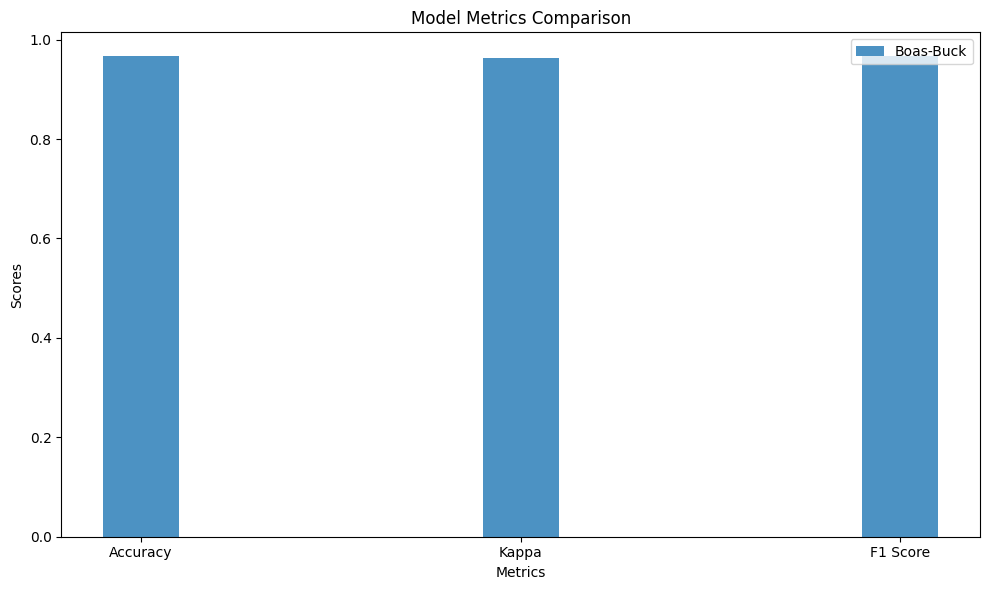

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
opacity = 0.8
index = np.arange(len(metrics.keys()))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors for each model

for i, model_name in enumerate(Model_Names):
    model_metrics = [metrics['Accuracy'][i], metrics['Kappa'][i], metrics['F1 Score'][i]]
    ax.bar(index + i * bar_width, model_metrics, bar_width,
           alpha=opacity, color=colors[i], label=model_name)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Model Metrics Comparison')
ax.set_xticks(index + bar_width * (len(Model_Names) - 1) / 2)
ax.set_xticklabels(metrics.keys())
ax.legend()

plt.tight_layout()
plt.show()